# Learn Azure Synapse Data Explorer
## Chapter 6 - Data analysis with KQL, Python and Power BI
### Exploring Data Explorer pool data with PySpark on Azure Synapse

In this notebook, we will use PySpark to retrieve data from our **Drone Telemetry** database on the Data Explorer pool, run through some examples on how to explore data using Azure Synapse notebooks. 

#### Library imports and data retrieval 
#### 
First, we will import the Python libraries that we will use in this notebook. Here's how they will be used: 

- MatplotLib: we will use the popular Python library to plot some charts in the bottom of the %notebook
- NumPy: used in this notebook to perform some matrix-wide mathematical computations
- Pandas: will be used to handle data when plotted with Matplotlib

Next, we will select all the data from the fleet data table and store it in memory on a Spark DataFrame which we will call **df**. 

Finally, we will display the DataFrame to glance at the data and make sure everything worked. 


In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.types import DateType
import seaborn 

mpl.rcParams['agg.path.chunksize'] = 10000

df  = spark.read \
    .format("com.microsoft.kusto.spark.synapse.datasource") \
    .option("spark.synapse.linkedService", "kustoPool") \
    .option("kustoCluster", "https://droneanalyticsadx.drone-analytics.kusto.azuresynapse.net") \
    .option("kustoDatabase", "drone-telemetry") \
    .option("kustoQuery", "['fleet data']") \
    .load()

display(df)

StatementMeta(sparkdronetl, 14, 1, Finished, Available)

SynapseWidget(Synapse.DataFrame, 17111a4b-9179-4b5f-a61b-5e8a7535b4e3)

#### Printing information about the data frame
#### 

Once we have a dataset in hands, its useful to peek at its structure to see what data we have in hand.  We can do that by using the display function again to show our Spark DataFrame, combined with the summary parameter set to True: 


In [23]:
display(df, summary=True)

StatementMeta(sparkdronetl, 14, 2, Finished, Available)

SynapseWidget(Synapse.DataFrame, 743efded-d778-45a7-82a5-9696cc582473)

This displays a summary of your data frame, listing all columns, their type, count of unique values, and count of missing values. Clicking any of the rows highlighted in blue will give you column statistics that include how many occurrences you have of each value present in that column. This is something useful to do immediately after you read data from some source (including, but not limited to data sourced from Data Explorer pools) so that you can better understand the schema of the data you will work with, its data types, how much data you have, and more. 

## Plotting charts

Azure Synapse notebooks offer robust support for data visualization. There are three main mechanisms you can use to visualize data with charts using notebooks: 
1)	The Chart feature of the query editor.
2)	Using the displayHTML command, combined with Java’s D3 library.
3)	Using external libraries for data visualization.
The Chart feature of the query editor works similarly to how we explored it in the Analyzing data with KQL section of this chapter. To plot charts using this feature in an Azure Synapse notebook, all you need to do is use the display function to show the results of a Sparl DataFrame, and then select the Chart toggle next to View. As an example, if we wanted to plot a line chart showing the trend of the CoreTemp column over a span of ten minutes, we could use the following code: 

In [24]:
display(df.select('CoreTemp','LocalDateTime') \
    .filter(df['LocalDateTime'] >= '2021-11-01 12:00:00') \
    .filter(df['LocalDateTime'] <= '2021-11-01 12:10:00'))


StatementMeta(sparkdronetl, 14, 3, Finished, Available)

SynapseWidget(Synapse.DataFrame, d535ca13-5b3c-4f38-a1f8-54ca573a5687)

This code block produces the result in a table format. To view it as a line chart, simply select the Chart toggle and set the Chart type option to Line chart. This feature is very simple to use and doesn’t require any additional libraries to work. However, the chart options are quite limited: you can’t format chat series, change colors, change legend settings, and other settings. For richer charts, you have to choose a different technique.

My favorite way to plot charts in notebooks is to use Python libraries such as Matplotlib, Seaborn, Plotly and others.These libraries are already pre-loaded into the Apache Spark environment provided by Azure Synapse, so all you have to do is import them before you use them. Let’s look at a few examples. 
One of the most popular libraries for data manipulation in Python is the Pandas library. It offers data structures for data manipulation, and a long list of features that make it easy to read and modify data in-memory using Python. Spark DataFrames offer a convenient toPandas method, which converts your Spark DataFrame to a Pandas data frame. Before we start using the Python libraries for data visualization, we have to convert our Spark DataFrame to a Pandas DataFrame, as most of these libraries were built to work with Pandas and not PySpark. 
Using the toPandas function is simple:

In [25]:
pandas_df = df.toPandas()

StatementMeta(sparkdronetl, 14, 4, Finished, Available)

Now that we have our new Pandas data frame, we can start building the charts. We will start by plotting a bell curve, which shows the normal distribution your data. For our example, we will use the _**CoreTemp**_ column. The bell curve helps understand the data distribution in your table, with the mean value at the top of the curve, and all the other possible values symmetrically distributed around the mean. Plotting the bell curve requires us to compute what’s called the probability density function for the values in the _**CoreTemp**_ column. The PDF calculates, for a value at any given sample, the relative likelihood that a variable would be close to a value in the dataset. 

![The probability density function (PDF)](https://github.com/PacktPublishing/Learn-Synapse-Data-Explorer/blob/main/Chapter%2006/probability%20density%20function.png?raw=true)

Some Python packages, such as SciPy, provide libraries to compute the PDF for you. In this example, we will simply build the expression and plug in the values to avoid importing a package only for this need. After we compute the PDF, we will use the Matplotlib library in Python to plot the chart. 

The code to compute the PDF and generate the bell curve is as follows: 

StatementMeta(sparkdronetl, 14, 5, Finished, Available)

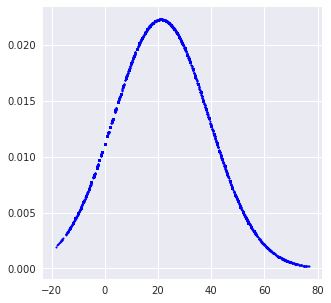

In [26]:
# Compute the PDF 
meanTemp = pandas_df['CoreTemp'].mean()
stdTemp = pandas_df['CoreTemp'].std()
y =  1/(stdTemp * np.sqrt(2 * np.pi)) * np.exp( - (pandas_df['CoreTemp'] - meanTemp)**2 / (2 * stdTemp**2))

# Plot the bell curve
plt.style.use('seaborn')
plt.figure(figsize = (5, 5))
plt.scatter(pandas_df['CoreTemp'], y, marker = '.', s = 10, color = 'blue')


Reviewing this chart, we can observe that the data is symmetrical, meaning that for new values of the CoreTemp value you can generally expect values with a probability to be closer to the center of the bell, where most values are. There is little tendency that this column will produce outliers, or many extreme values. 

Another way to visualize how values are distributed in a certain column is to use a histogram. They are much simpler to produce and give you an easy way to visualize the most common value ranges for your column, as well as the data distribution across the full range of your data. You can produce a histogram easily using Matplotlib: 

StatementMeta(sparkdronetl, 14, 7, Finished, Available)

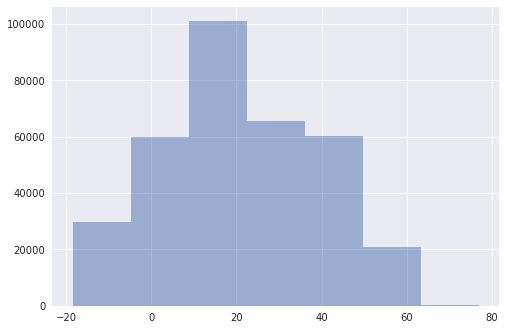

In [28]:
plt.hist(pandas_df['CoreTemp'], bins=7, alpha=0.5)
plt.show()

In this case, we can see that there are approximately 30,000 occurrences of _**CoreTemp**_ with values somewhere between about -19 and -3, close to 60,000 values between about -3 and 9, and so on. 

Another useful way to get a good sense of how your data is spread out is to use box plots. They allow you to easily see the spread and skewness of the values in your dataset by plotting their quartiles. Box plots are also useful to identify outliers as they plot these data points individually beyond the chart area, making them obvious and easy to spot. 
Producing box plots with Matplotlib in Python is a breeze. Here is an example: 


StatementMeta(sparkdronetl, 14, 8, Finished, Available)

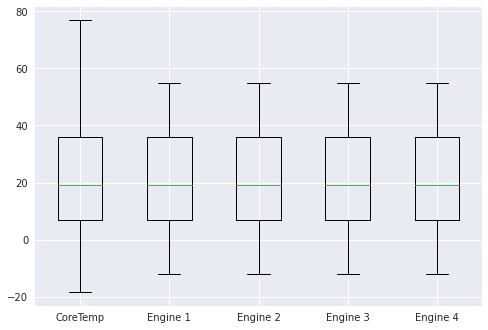

In [29]:
plt.boxplot(pandas_df[['CoreTemp','Engine1Temp',
    'Engine2Temp','Engine3Temp','Engine4Temp']])
plt.xticks([1,2,3,4,5], ['CoreTemp','Engine 1',
    'Engine 2','Engine 3','Engine 4'])
plt.show()

In this chart, we observe the following: 
- The areas in the rectangle provide a range from the first quartile (which is the 25th percentile in a normal distribution) to the third quartile (75th percentile). 
- The maximum and the minimum values are the ranges expressed beyond the rectangles.
- The median value is expressed by the horizontal line inside the rectangles.

We can also notice that the data distribution is consistent across the temperature values from Engine 1 through Engine 4, which is what we would expect. Additionally, the _**CoreTemp**_ values observe a broader temperature range when compared to that of the individual engines, which could indicate an issue with the drone’s core temperature. 
 
Let’s look at one final example of plots. A common task when analyzing data is to try to understand how variables (or columns) in your dataset relate to each other, and how much correlation there is in between them. This can be achieved by using a correlation matrix. Pandas provides a convenient corr function which, given a certain data frame, computes the correlation of columns in such dataset excluding null values. For example, the following code produces a correlation matrix for a subset of our data frame: 


In [30]:
correlation_matrix = pandas_df[['Engine1RPM','Engine1Temp','CoreTemp','BatteryTemp','Altitude','Speed','DistanceFromBase','RFSignal','PayloadWeight']].corr()

StatementMeta(sparkdronetl, 14, 9, Finished, Available)

Now that we have the correlation matrix stored in the correlation_matrix variable, we can use the seaborn library to produce a heatmap which visually represents our matrix. 

StatementMeta(sparkdronetl, 14, 10, Finished, Available)

<AxesSubplot:>

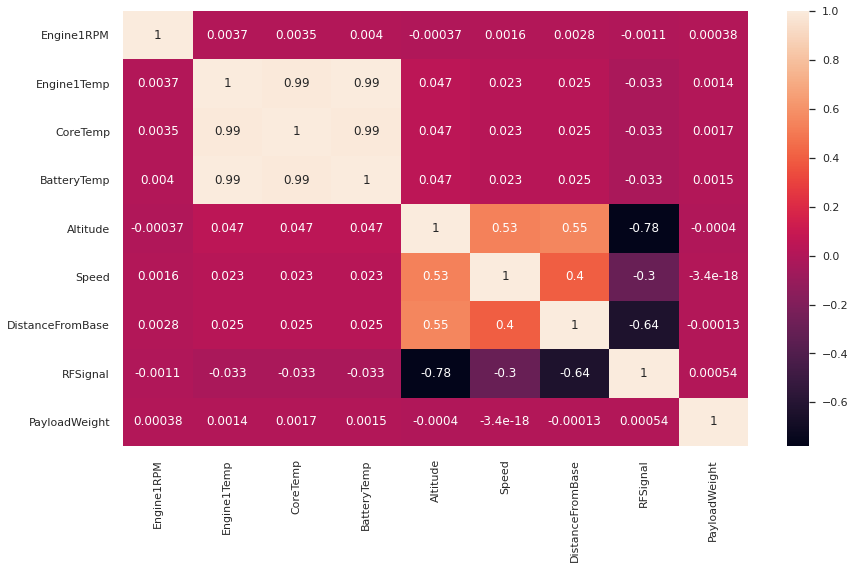

In [31]:
seaborn.set(rc = {'figure.figsize':(14, 8)})
seaborn.heatmap(correlation_matrix, annot=True)

The values of a correlation matrix range between -1 and 1. Values that are closer to -1 are called negative correlations, while values closer to 1 are called positive correlations. Negative correlations indicate that the variables are related, but tend to move in opposite directions, while positive correlations indicate that the variables are also related, but tending to move in the same direction. Values closer to 0 represent a weak, or inexistent linear relationship between the variables. 

In the example illustrated in Figure 6.28, as an example, we notice that probably there is collinearity between _**RFSignal**_ and _**Altitude**_, with a correlation coefficient **-0.78**. 


## Performing data transformation tasks 

So far, we’ve loaded the data from the Data Explorer pool into a Spark DataFrame and explored the data to understand its schema and the distribution of some columns. We will now look at ways to make this data easier to read and consume for an end user. 

For the first data transformation task, we will assume a scenario where users will need to build a report and needs a date column to easily filter data, and maybe produce some charts. The user will need the date only, not the specific time the telemetry event was captured. We notice that the table we are working with has a column named _**DateTime**_, and a column named _**LocalDateTime**_. The _**DateTime**_ column stores the date and time in the universal time coordinated (UTC) format, while the _**LocalDateTime**_ stores the same date and time, but at the local time zone. We will produce a new column which contains the date only, without the time, derived from the _**LocalDateTime**_ column. The new column will be named _**LocalDate**_. We can achieve this need by creating a new code cell and using the following code snippet: 


In [32]:
df = df.withColumn('LocalDate', df['LocalDateTime'].cast(DateType()))

StatementMeta(sparkdronetl, 14, 11, Finished, Available)

The **withColumn** function of the Spark DataFrame object returns a new DataFrame with a new column, or replaces an existing column of the same name with a new one. The name of the new column (or the one being replaced) is the first parameter of the function (_**LocalDate**_ in this example), and the new value that the column will receive is contained in the second parameter (in our case, the _**LocalDateTime**_ column cast to **DateType**). 

We can then verify that our data transformation worked by displaying a few rows from our DataFrame using the following code: 


In [33]:
display(df.select('LocalDateTime','LocalDate'))

StatementMeta(sparkdronetl, 14, 12, Finished, Available)

SynapseWidget(Synapse.DataFrame, 0c450be8-79b1-45db-9aa6-100fbcff3831)

You can also use data transformation tasks to produce new columns based on calculations. As an example, our dataset contains a _**CoreTemp**_ column which stores the core temperature of the drone at the time the telemetry event was generated. This column contains temperature values using the Celsius scale. Let’s say we want to produce a new column, which displays the equivalent temperature in the Fahrenheit scale. We can perform this task by using the same **withColumn** function we used before, but by applying a simple formula as the column expression for the new column. 

For simplicity, you can create a new code cell which contains the code to produce the new column and to visualize a few rows with the results at once. 

In [34]:
from pyspark.sql.functions import round 
df = df.withColumn('CoreTemp-F', round(df['CoreTemp'] * 1.8 + 32,2))
display(df.select('CoreTemp','CoreTemp-F'))

StatementMeta(sparkdronetl, 14, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, d5658d34-65cb-4af0-af62-ac96a9e86165)

In this case, we see that the row that contains a _**CoreTemp**_ value of 18 now also contains a _**CoreTemp-F**_ column with the value 64.4. The same applies to each row in the data frame, each row with their respective values. 

As a final example on data transformation, let’s see how we can extract data from the JSON columns in the dataset to make data analysis easier for our end user. There are two JSON columns in our source data: _**DeviceData**_ and _**EventData**_. These columns contain a JSON document, which may provide different values depending on the telemetry event. An example of the _**DeviceData**_ column has the following data: 

```
{
'guid': '90C5BED1-232B-432A-B559-2DAB2F59A97F',
'deviceID': 'drn00001', 
'deviceName': 'DT-F-725C'
}
```
This is a simple JSON document with a collection of name/value pairs which provide some attributes about the drone that generated the telemetry event. Now let’s look at an example of the _**EventData**_ column: 

```
{
'averageSpeed': 75, 
'stageDistance': 2938, 
'accumulatedDistance': 6977
}

```

This is also a simple JSON document with value/pair combinations. These values provide additional attributes about the drone at the time the telemetry event was generated. 

Let’s think of an example where an analyst will want to know the drones in the fleet with the highest accumulated distance, as they may require maintenance after reaching a certain mileage. For this purpose, we will create two new columns: one that makes it easier to see what the name of the device in the telemetry event is, and one with the accumulated distance of that drone. We can achieve this by using the following code snippet: 

In [35]:
from pyspark.sql.functions import col, get_json_object
df = df.withColumn('deviceName', get_json_object(col('DeviceData'),'$.deviceName').alias('deviceName'))
df = df.withColumn('accumulatedDistance', get_json_object(col('EventData'),'$.accumulatedDistance').alias('accumulatedDistance').cast('int'))
display(df.select('DeviceData','EventData','deviceName','accumulatedDistance'))

StatementMeta(sparkdronetl, 14, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, d2ed3cc7-95ef-491b-8d9c-234714aad837)

It’s important to note that none of these data transformation tasks resulted in data loss. We are not replacing the values in the source columns with the “transformed” ones, we are always creating new columns with the new, desired values. Additionally, these changes are not written back to the source table schema in the Data Explorer pool database.

However, if you would like to perform further analysis using the new columns we just created as part of the data transformation process, there is a way to persist this data and offer a dataset for users to consume. This can be done by implementing a lake database. 

## Creating a lake database

A lake database allows you to store data in ADLS Gen2 while maintaining database and table metadata in Azure Synapse. All your data will be physically written in parquet, delta, or CSV files, but exposed to users as if they were regular SQL tables and databases. Users can then perform queries normally using the serverless SQL pools, or Apache Spark pools, using the SQL and Spark APIs. 

Using the lake database, we can persist the Spark DataFrame we have been working on to disk, with all the data transformations, and use it as if it were a SQL table. This SQL table can be used for user queries, Power BI reports, or any other purpose that a SQL table could satisfy. 

To persist our Spark DataFrame on the lake database, we should first create a new database:

In [36]:
spark.sql('CREATE DATABASE IF NOT EXISTS drone_telemetry')

StatementMeta(sparkdronetl, 14, 15, Finished, Available)

DataFrame[]

Next, we will switch the context to the new database with the **USE drone_telemetry** command, and then we will use the Spark DataFrame method **saveAsTable** to write the contents of our Spark DataFrame to this new managed table. 

In [37]:
spark.sql('USE drone_telemetry')
df.write.mode('overwrite').saveAsTable('fleet_data')

StatementMeta(sparkdronetl, 14, 16, Finished, Available)